# Combing Models

Now we might want to combine different models together. For example, we might want to fit a transit as well as its systematics (e.g. a polynomial in time/x/y/background).

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
Running on numpy v1.22.1


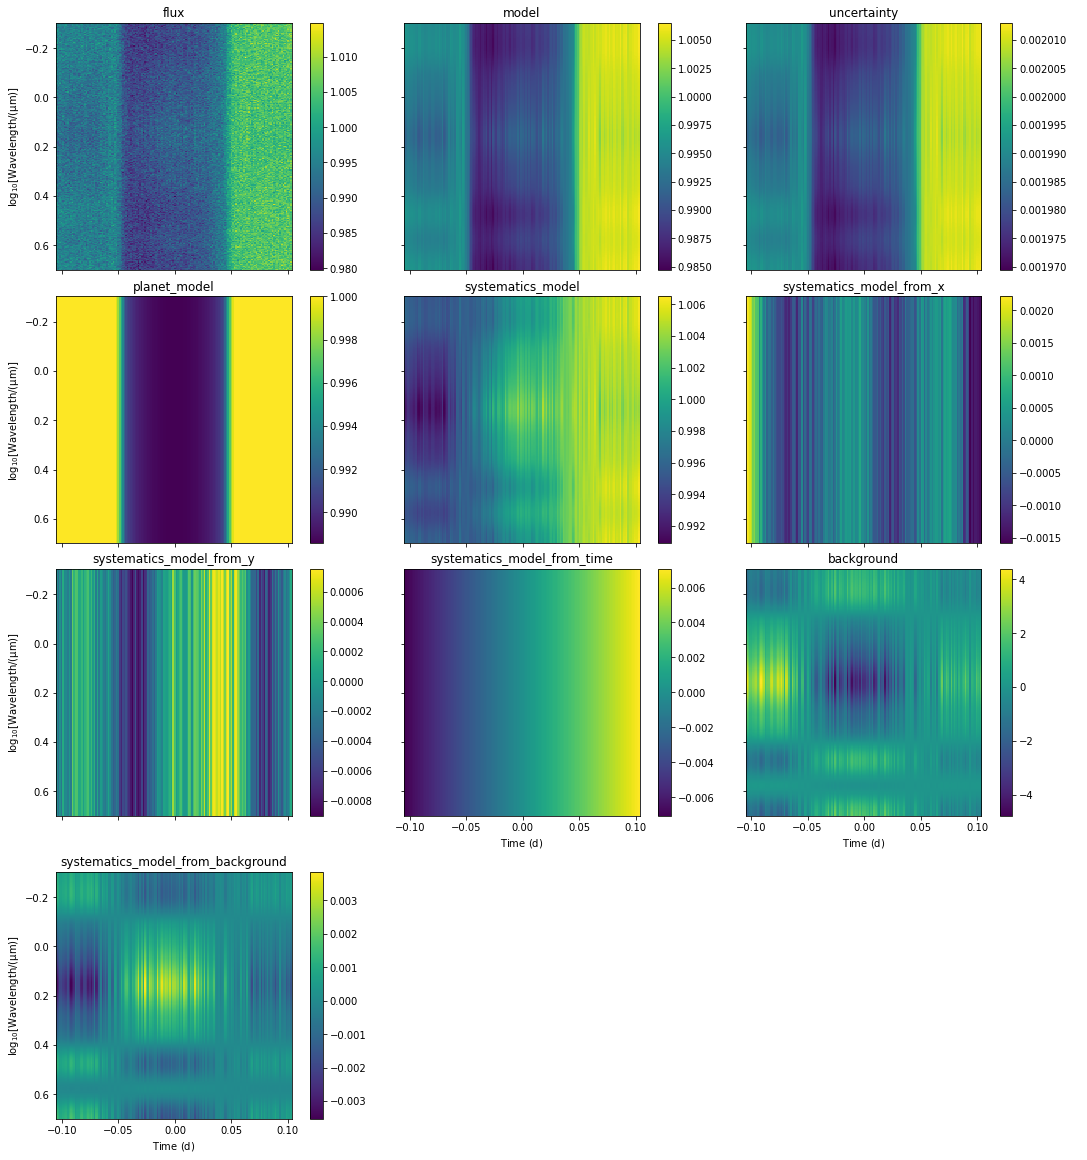

In [2]:
s = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [4]:
cm = t * (b + b_x + b_y + b_bkg)
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) + sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>) * transit(<chromatic transit model 🌈>)

In [5]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>,
 'transit': <chromatic transit model 🌈>}

In [6]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 

In [7]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13332.18it/s]


If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize!

In [8]:
print(cm.pymc3_model)

                            stime_p_1 ~ Normal
                               sx_p_1 ~ Normal
                               sy_p_1 ~ Normal
                             sbkg_p_1 ~ Normal
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                       stime_model_w0 ~ Deterministic
                       stime_model_w1 ~ Deterministic
                       stime_model_w2 ~ Deterministic
                       stime_model_w3 ~ Deterministic
                       stime_model_w4 ~ D

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.summarize() before calling this step!


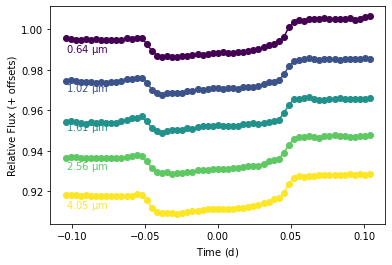

In [9]:
cm.plot_lightcurves()

In [10]:
opt = cm.optimize()
cm.sample(start=opt, tune=4000, draws=4000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -114864.82782933138 -> -60211.0607444618

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]



🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppfSampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 494 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value en

                             mean        sd    hdi_3%   hdi_97%     mcse_mean  \
stime_p_1                0.068280  0.000197  0.067906  0.068642  1.500000e-06   
sx_p_1                  -0.001058  0.000019 -0.001093 -0.001024  2.000000e-07   
sy_p_1                   0.000575  0.000020  0.000539  0.000613  2.000000e-07   
sbkg_p_1                -0.000772  0.000016 -0.000802 -0.000742  1.000000e-07   
transit_radius_ratio_w0  0.099904  0.000307  0.099329  0.100459  3.800000e-06   
...                           ...       ...       ...       ...           ...   
combined_model_w4[56]    1.005416  0.000021  1.005377  1.005454  2.000000e-07   
combined_model_w4[57]    1.004823  0.000028  1.004770  1.004875  2.000000e-07   
combined_model_w4[58]    1.005264  0.000027  1.005214  1.005313  2.000000e-07   
combined_model_w4[59]    1.005569  0.000027  1.005520  1.005620  2.000000e-07   
combined_model_w4[60]    1.006062  0.000027  1.006011  1.006111  2.000000e-07   

                           


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

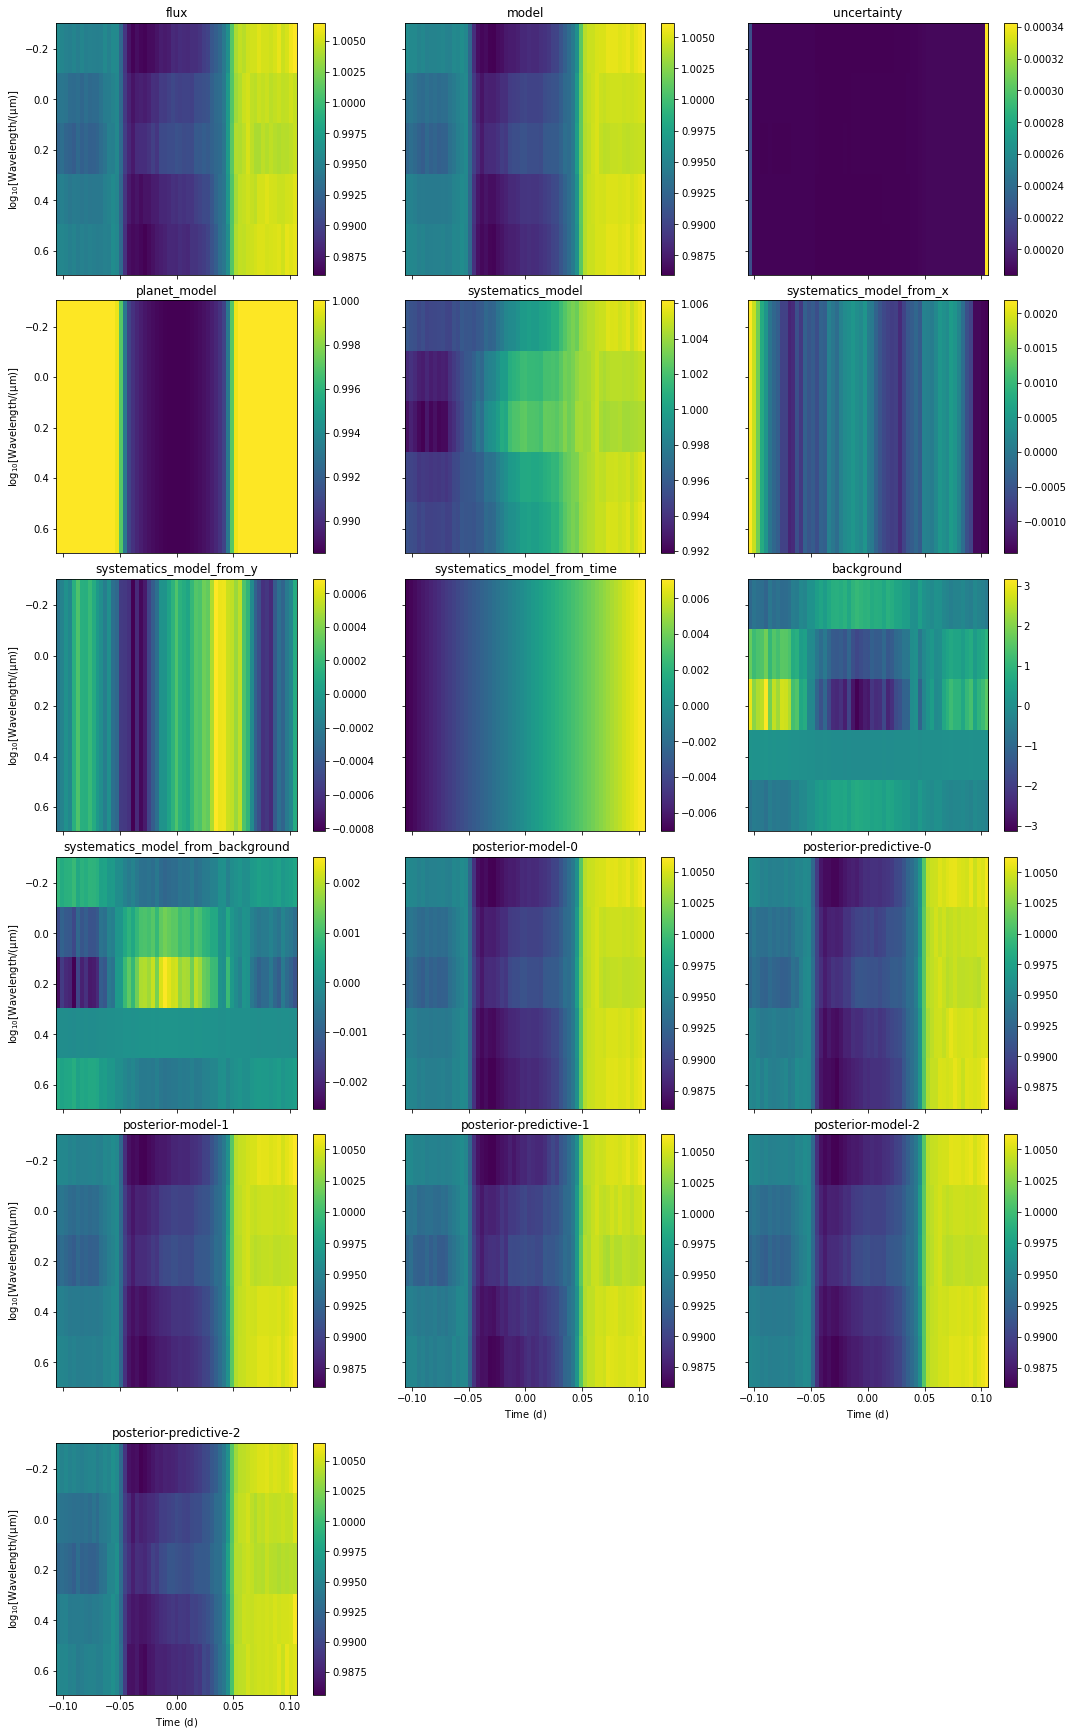

In [11]:
cm.plot_posteriors()

We have several different methods to plot the modelled results:

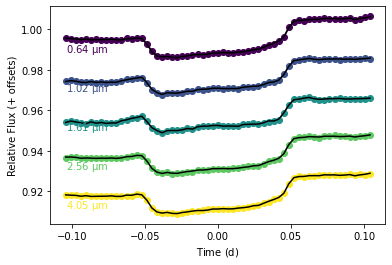

In [12]:
cm.plot_lightcurves()

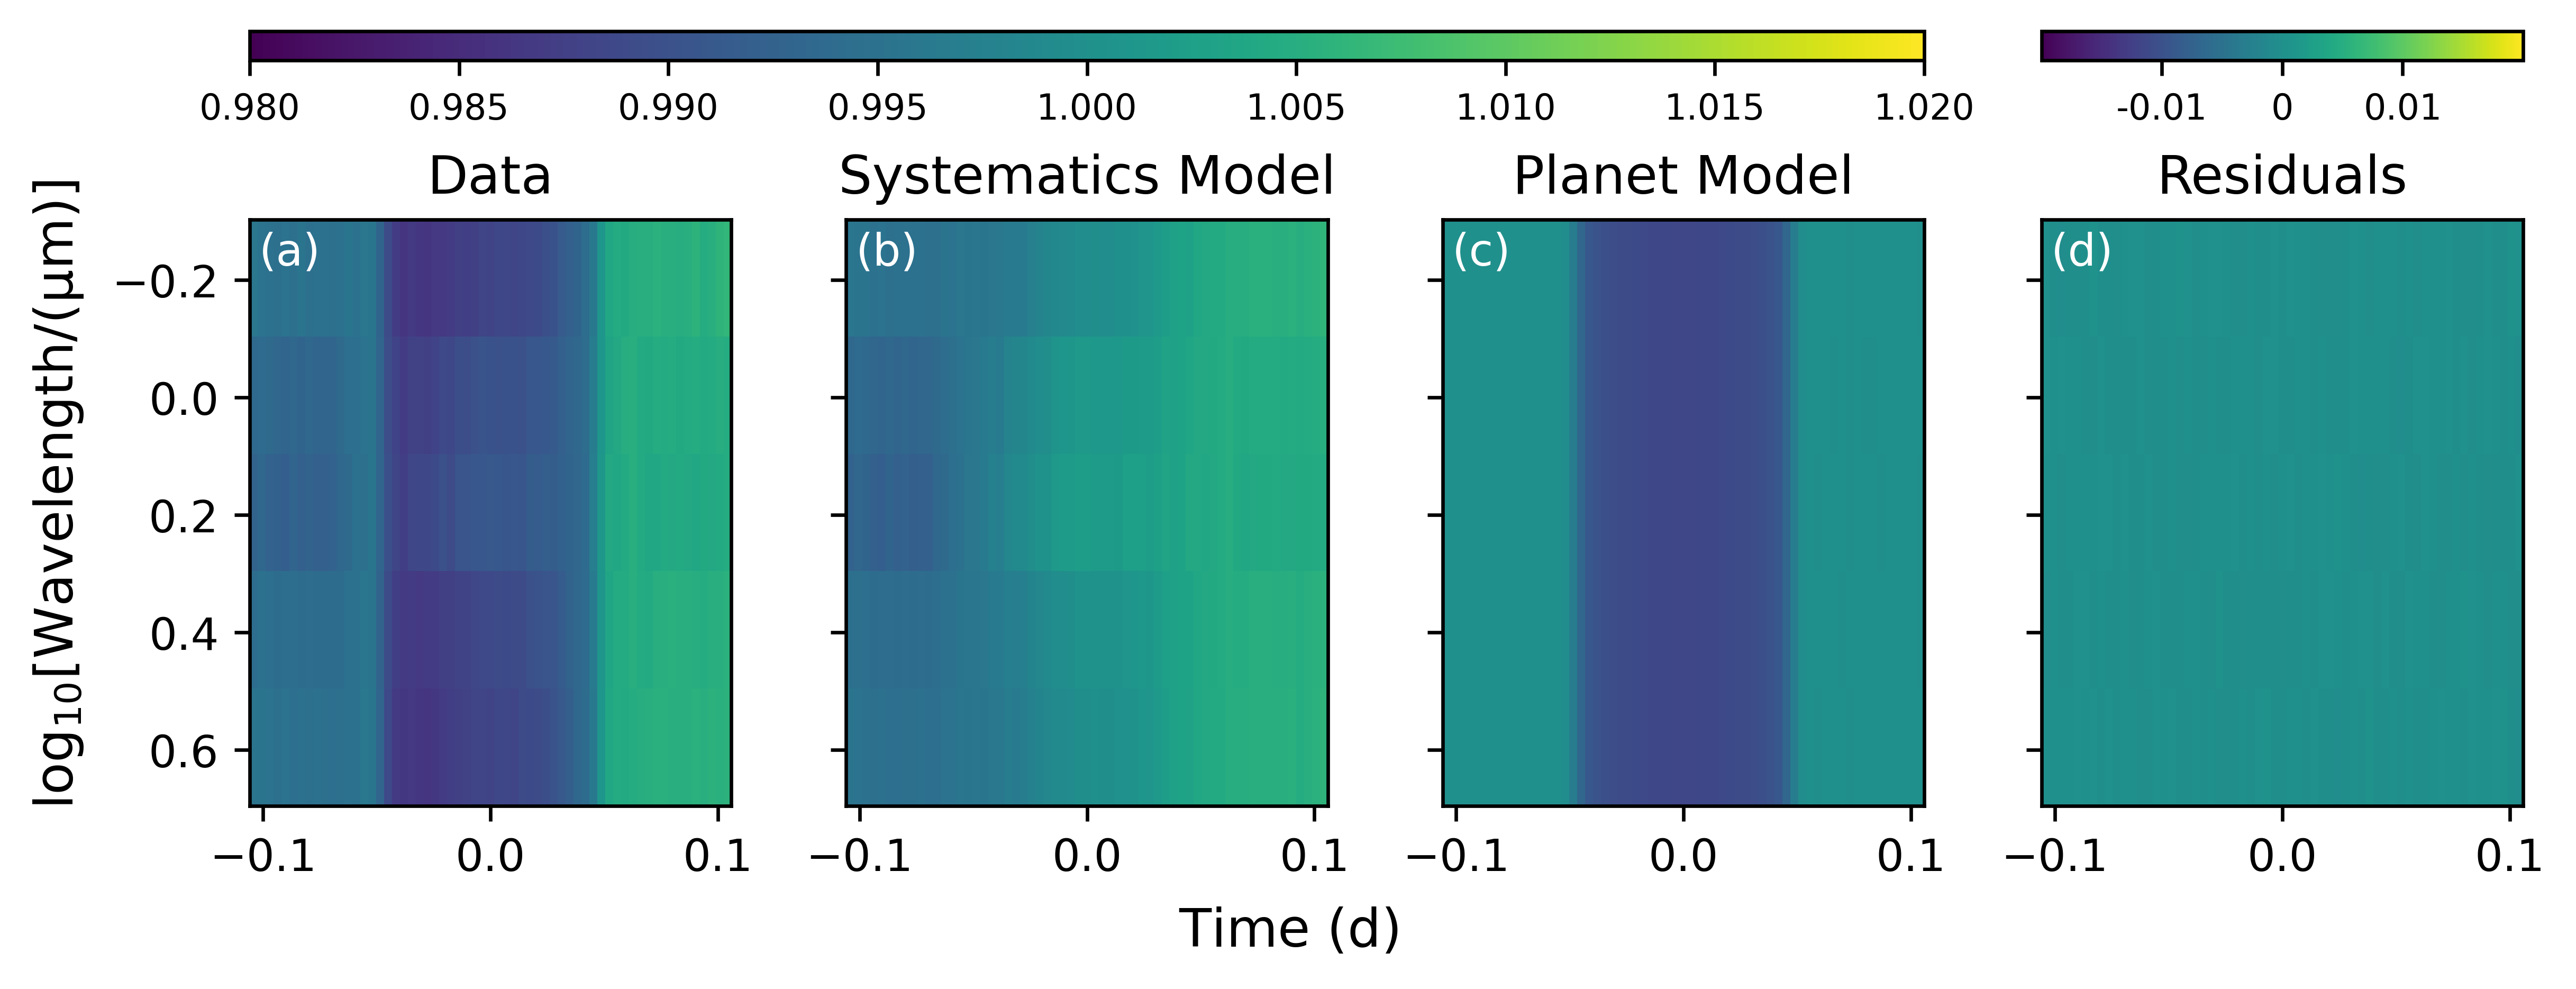

In [16]:
cm.imshow_with_models()

  0%|          | 0/5 [00:00<?, ?it/s]

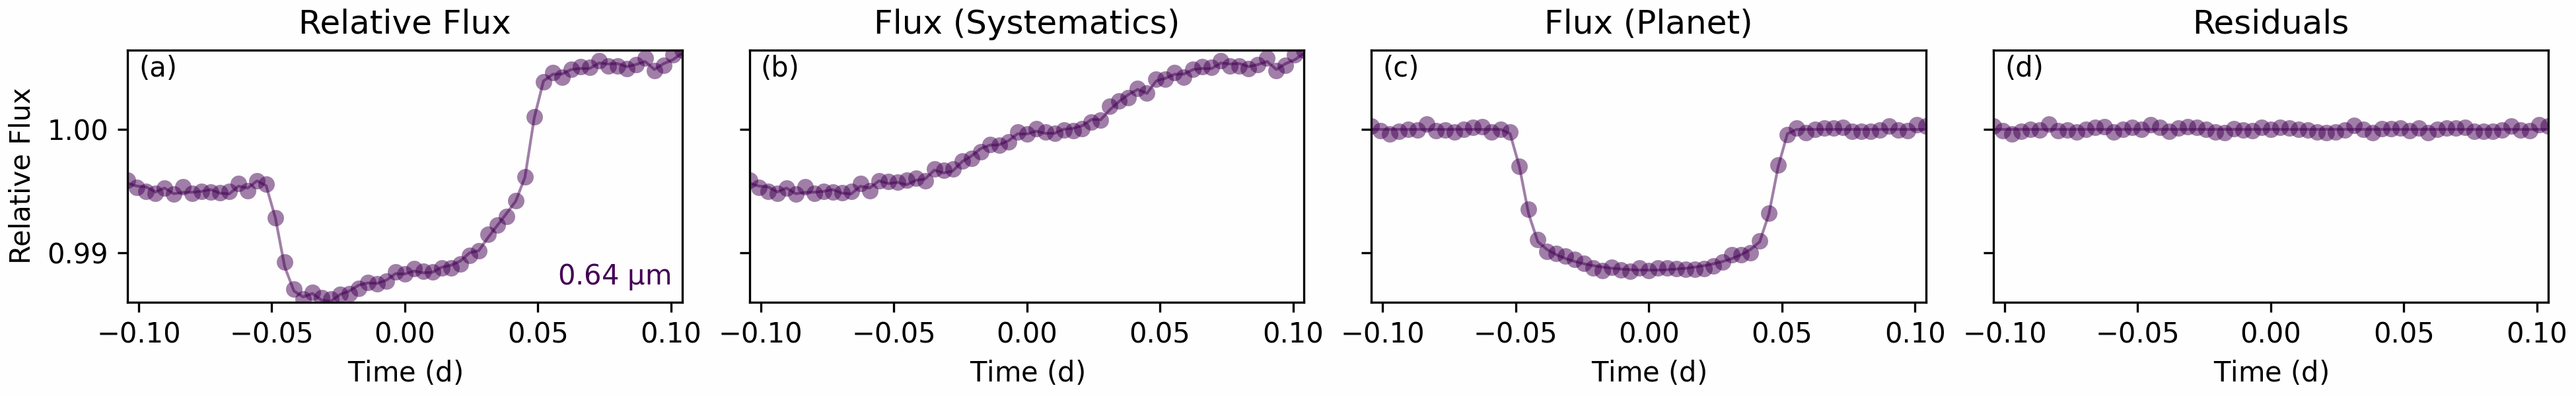

In [15]:
cm.animate_with_models('test.gif', orientation='horizontal')

In [20]:
cm.get_results()

AttributeError: 'tuple' object has no attribute 'get_results'